# Implementation verification: Toxicokinetics

The examples below should demonstrate that toxicokinetics are correctly simulated. Also, arbitrary numbers of stressors and numbers of PMoAs per stressor can be simulated.

In [1]:
using Revise
@time using DEBBase
@time using DoseResponse
using DataFrames
using BenchmarkTools
using Plots, StatsPlots, Plots.Measures
default(leg = false, lw = 1.5, titlefontsize = 10)

 68.181823 seconds (31.83 M allocations: 2.193 GiB, 1.94% gc time, 0.93% compilation time: 58% of which was recompilation)
  0.001507 seconds (457 allocations: 30.688 KiB)

## Single stressor - single PMoA

In the simplest case, we have a single stressor with a single PMoA.

In [2]:
C_W_vec = 10 .^ range(log10(0.1), log10(2), 3) |> x -> round.(x, sigdigits = 2)
k_D_vec = 10 .^ range(log10(0.01), log10(1.0), 5) |> x -> round.(x, sigdigits = 2)

5-element Vector{Float64}:
 0.01
 0.032
 0.1
 0.32
 1.0

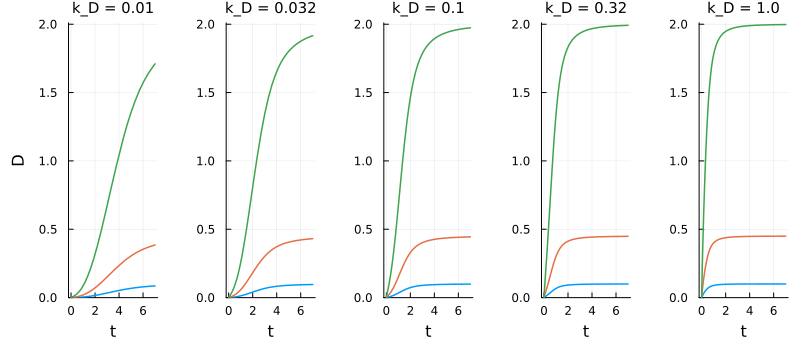

In [3]:
p = plot(
    layout = (1,length(k_D_vec)), 
    title = hcat(["k_D = $(k_D)" for k_D in unique(k_D_vec)]...),
    xlabel = "t",
    ylabel = ["D" "" "" "" ""],
    size = (800,350), 
    bottommargin = 5mm,
    leftmargin = 5mm, 
    ylim = (0, 2.01)
    )

for (i,k_D) in enumerate(k_D_vec)
    for C_W in C_W_vec

        glb = GlobalBaseParams(C_W = [C_W], t_max = 7)
        deb = DEBBaseParams(
            k_D = [k_D]
            )
        out = simulator(glb, deb)
        
        @df out plot!(p, :t, :D_1, subplot = i)
    end
end
display(p)

## Single stressor - multiple PMoAs

In a slightly more elaborate case, we might have a single stressor which acts via multiple PMoAs.

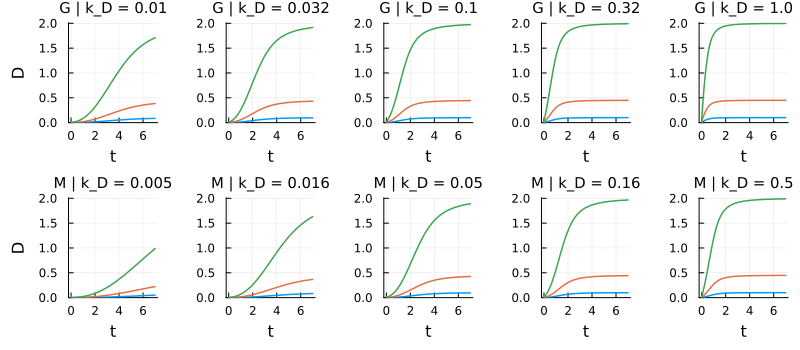

In [4]:
p = plot( # define plot
    layout = (2,length(k_D_vec)), 
    xlabel = "t",
    ylabel = ["D" "" "" "" ""],
    size = (800,350), 
    bottommargin = 5mm,
    leftmargin = 5mm, 
    ylim = (0, 2.01)
    )

for (i,k_D) in enumerate(k_D_vec)
    for C_W in C_W_vec

        glb = GlobalBaseParams(C_W = [C_W], t_max = 7)
        deb = DEBBaseParams(
            k_D = hcat([k_D; k_D * .25]...) # we have two PMoAs, indicated by two k_D values
            )
        out = simulator(glb, deb)
        
        @df out plot!(p, :t, :D_1_1, title = "G | k_D = $(k_D)", subplot = i)
        @df out plot!(p, :t, :D_2_1, title = "M | k_D = $(k_D/2)", subplot = i + length(k_D_vec))
    end
end
display(p)

## Multiple stressors - multiple PMoAs

Finally, we could have multiple stressors, each with mutliple PMoAs. <br>
Below we simulate TK for two stressors and two PMoAs each, as indicated by the `C_W`-Vector and `k_D`-Matrix.

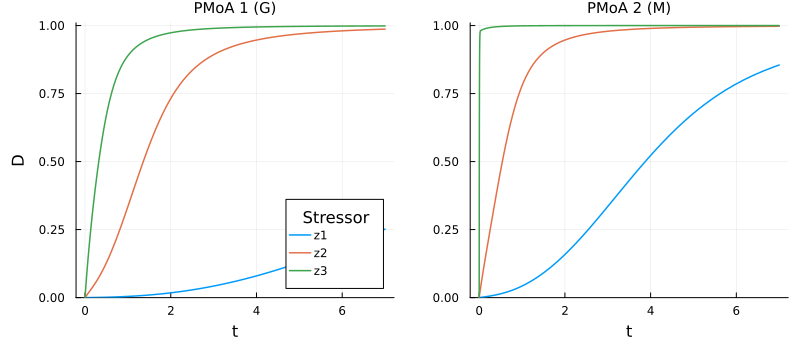

In [5]:
p = plot( # define plot
    layout = (1,2), 
    xlabel = "t",
    ylabel = ["D" "" "" "" ""],
    size = (800,350), 
    bottommargin = 5mm,
    leftmargin = 5mm, 
    ylim = (0, 1.01), 
    leg = true, legendtitle = ["Stressor" nothing],
    title = ["PMoA 1 (G)" "PMoA 2 (M)"]
    )


glb = GlobalBaseParams(C_W = [1., 1., 1.], t_max = 7)
deb = DEBBaseParams(
    # k_D-Matrix for two PMoAs and three stressors
    k_D = [
        .001 .01; 
        .1 .5; 
        1. 100.
        ],
    # drc_functs and drc_functs also currently has to match exactly in shape
    # this might be simplified so that the same drc functs are assumed per PMoA across stressors
    drc_functs = [
        LL2 LL2M;
        LL2 LL2M;
        LL2 LL2M;
        LL2 LL2M
    ],
    drc_params = [
        (1., 2.) (1., 2.);
        (1., 2.) (1., 2.);
        (1., 2.) (1., 2.)
    ])

out = simulator(glb, deb)

# damage for stressor 1
@df out plot!(p, :t, :D_1_1, subplot = 1, label = "z1")
@df out plot!(p, :t, :D_2_1, subplot = 2, label = nothing)

# damage for stressor 2
@df out plot!(p, :t, :D_1_2, subplot = 1, label = "z2")
@df out plot!(p, :t, :D_2_2, subplot = 2, label = nothing)

# damage for stressor 3
@df out plot!(p, :t, :D_1_3, subplot = 1, label = "z3")
@df out plot!(p, :t, :D_2_3, subplot = 2, label = nothing)
 
display(p)

With the parameters set above, we should see that toxicokinetics increases with the stressors index, and that for each stressor, toxicokinetics for PMoA 2 is faster than for PMoA 1. 

## Modifying the model: Simplified TK

Below we give an example where the model is modified to use a different equation for `DDot`. <br>
This process should be further simplified, e.g. using metaprogramming and inheritance-like concepts.

In [17]:
using DEBBase, Parameters, ComponentArrays, DifferentialEquations
import DEBBase:simulator

In [18]:
@with_kw mutable struct MinTKParams <: AbstractParams
    X_emb_int::Float64 = 19.42
    K_X::Float64 = 1.
    Idot_max_rel::Float64 = 22.9
    Idot_max_rel_emb::Float64 = 22.9
    kappa::Float64 = 0.539
    eta_IA::Float64 = 0.33
    eta_AS::Float64 = 0.8
    eta_SA::Float64 = 0.8
    eta_AR::Float64 = 0.95
    k_M::Float64 = 0.59
    k_J::Float64 = 0.
    H_p::Float64 = 100.
    
    k_D::Union{Vector{Float64}, Matrix{Float64}} = [1.0, 1.0] # dominant rate constants
    # TODO: set drc functs dynamically under the assumption of two-parameter log-logistic function
    drc_functs::Matrix{Function} = [
        LL2 LL2M LL2 LL2 LL2h;
        LL2 LL2M LL2 LL2 LL2h;
        ]
    drc_params::Matrix{NTuple} = [
        (1., 2.) (1., 2.) (1., 2.) (1., 2.) (1., 2.);
        (1., 2.) (1., 2.) (1., 2.) (1., 2.) (1., 2.)
        ]
end

@inline function Ddot(
    glb::AbstractParams,
    deb::MinTKParams,
    du::ComponentVector,
    u::ComponentVector
    )
    return @. deb.k_D * (u.C_W - u.D)
end

function MinTK!(du, u, p, t)

    #### boilerplate

    glb::GlobalBaseParams, deb::MinTKParams = p # unpack parameters
    @unpack X_p, X_emb, S, H, R, D, C_W = u # unpack state variables

    S = max(0, S) # control for negative values
    life_stage = DEBBase.determine_life_stage(deb; H = H, X_emb = X_emb)
    
    #### auxiliary state variables

    idot = DEBBase.Idot(glb, deb, du, u; life_stage = life_stage)
    adot = DEBBase.Adot(glb, deb, du, u; Idot = idot)
    mdot = DEBBase.Mdot(glb, deb, du, u)
    jdot = DEBBase.Jdot(glb, deb, du, u)

    #### major state variables

    du.X_p = DEBBase.embryo(life_stage) ? 0. : glb.Xdot_in - idot
    du.X_emb = DEBBase.embryo(life_stage) ? -idot : 0.0
    du.S = DEBBase.Sdot(glb, deb, du, u; Adot = adot, Mdot = mdot)
    du.H = DEBBase.Hdot(glb, deb, du, u; Adot = adot, Jdot = jdot, life_stage = life_stage)
    du.R = DEBBase.Rdot(glb, deb, du, u; Adot = adot, Jdot = jdot, life_stage = life_stage)
    du.D = Ddot(glb, deb, du, u)
    du.C_W = zeros(length(glb.C_W))
end

function simulator(
    glb::AbstractParams,
    deb::MinTKParams
    )
    
    @assert size(deb.k_D)[1] >= length(glb.C_W) "Size of k_D ($(size(deb.k_D))) does not match number of stressors indicated in glb.C_W ($(length(glb.C_W)))."
    @assert size(deb.drc_functs)[1] >= length(glb.C_W) "Size of drc_functs ($(size(deb.drc_functs))) does not match number of stressors indicated in glb.C_W ($(length(glb.C_W)))."
    @assert size(deb.drc_params)[1] >= length(glb.C_W) "Size of drc_params ($(size(deb.drc_params))) does not match number of stressors indicated in glb.C_W ($(length(glb.C_W)))."

    u = ComponentArray( # initial states
        X_p = glb.Xdot_in, # initial resource abundance equal to influx rate
        X_emb = deb.X_emb_int, # initial mass of vitellus
        S = deb.X_emb_int * 0.01, # initial structure is a small fraction of initial reserve // mass of vitellus
        H = 0., # maturity
        R = 0., # reproduction buffer
        D = zeros(size(deb.k_D)),
        C_W = glb.C_W
    )

    tspan = (0, glb.t_max) # define the timespan
    prob = ODEProblem(MinTK!, u, tspan, (glb = glb, deb = deb)) # define the problem
    
    # TODO: flatten D-Matrix into multiple columns in output dataframe
    sol = solve(prob, reltol = 1e-6, abstol = 1e-10) # get solution to the IVP
    simout = DEBBase.sol_to_df(sol)
  
    return simout
end

simulator (generic function with 2 methods)

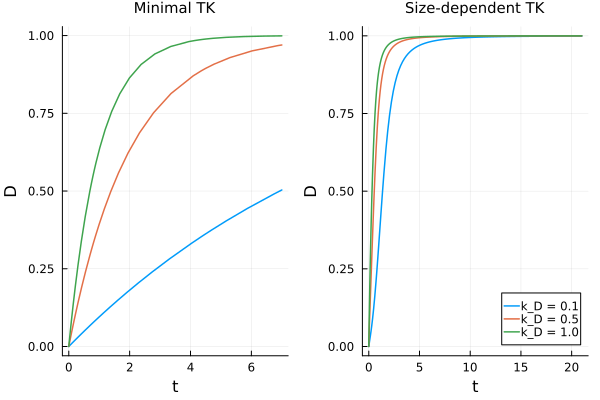

In [23]:
p = plot(layout = (1,2), title = ["Minimal TK" "Size-dependent TK"])

for k_D in [0.1, 0.5, 1.]

    out = simulator(GlobalBaseParams(C_W = [1.], t_max = 7.), MinTKParams(k_D = [k_D]))

    @df out plot!(p, 
        :t, :D_1,
        xlabel = "t", ylabel = "D", 
        subplot = 1
    )

    out = DEBBase.simulator(GlobalBaseParams(C_W = [1.], t_max = 7.), DEBBaseParams(k_D = [k_D]))

    @df out plot!(p, 
    :t, :D_1, leg = true, label = "k_D = $(k_D)", 
    xlabel = "t", ylabel = "D", 
    subplot = 2
    )
end
display(p)